# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [3]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [4]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_3.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_3_mask.tif


### creating final datset

In [7]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


# 2: DATA VISUALIZATION

In [8]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [9]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

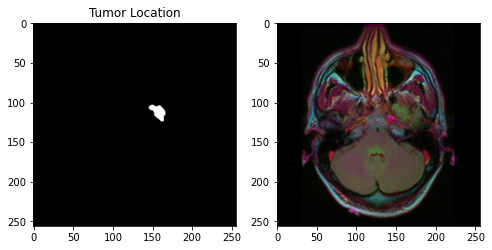

In [10]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [11]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

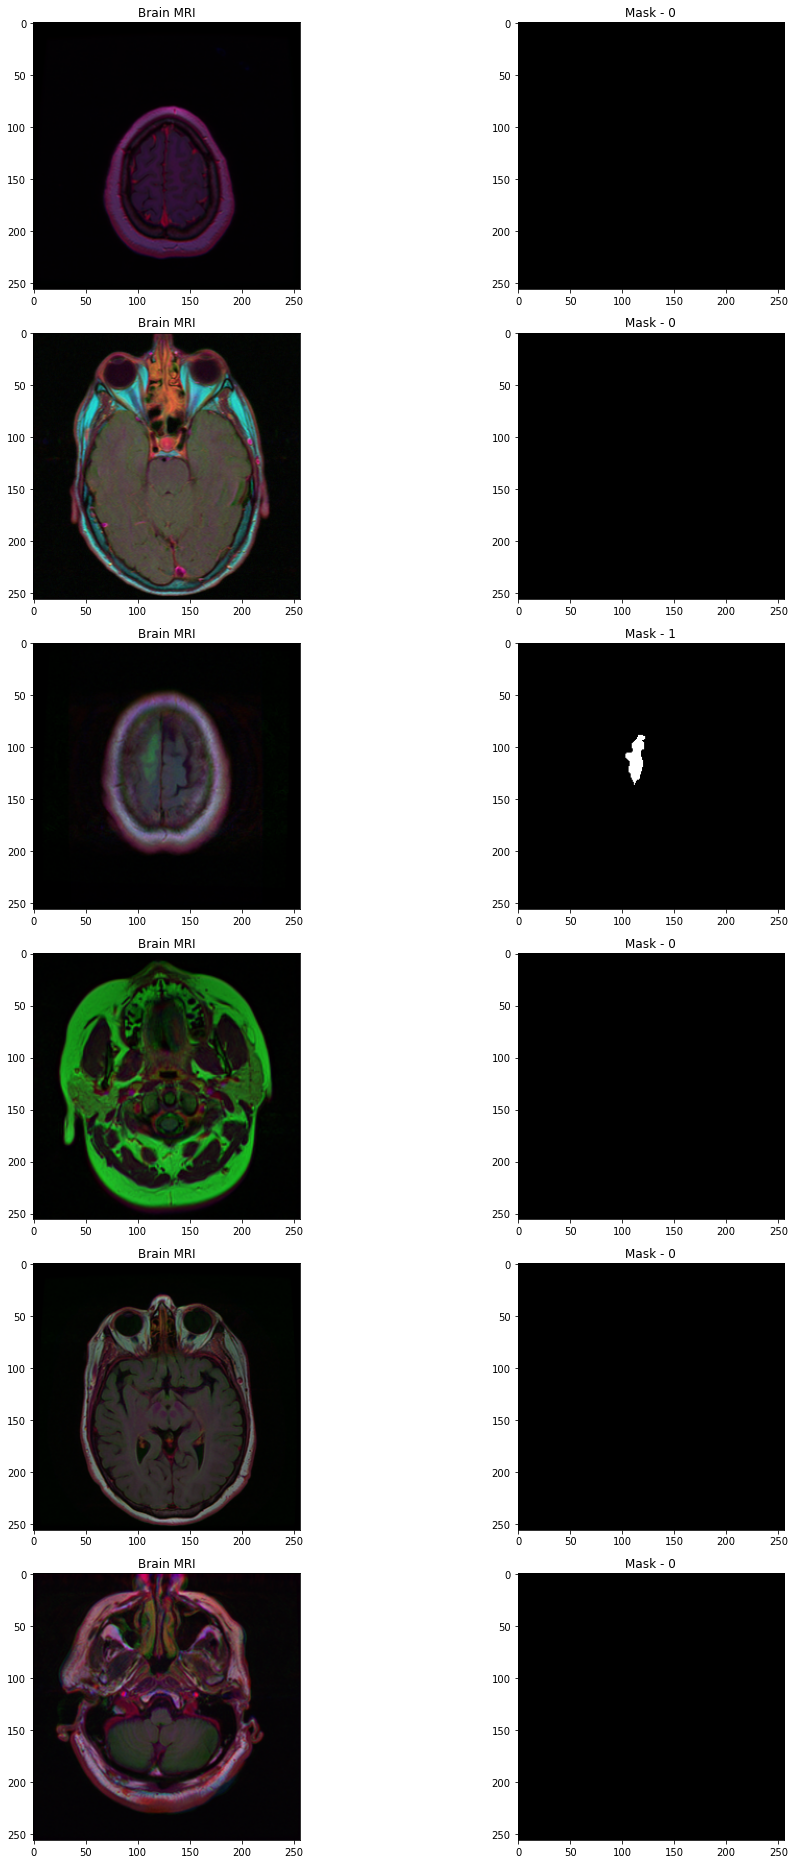

In [12]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

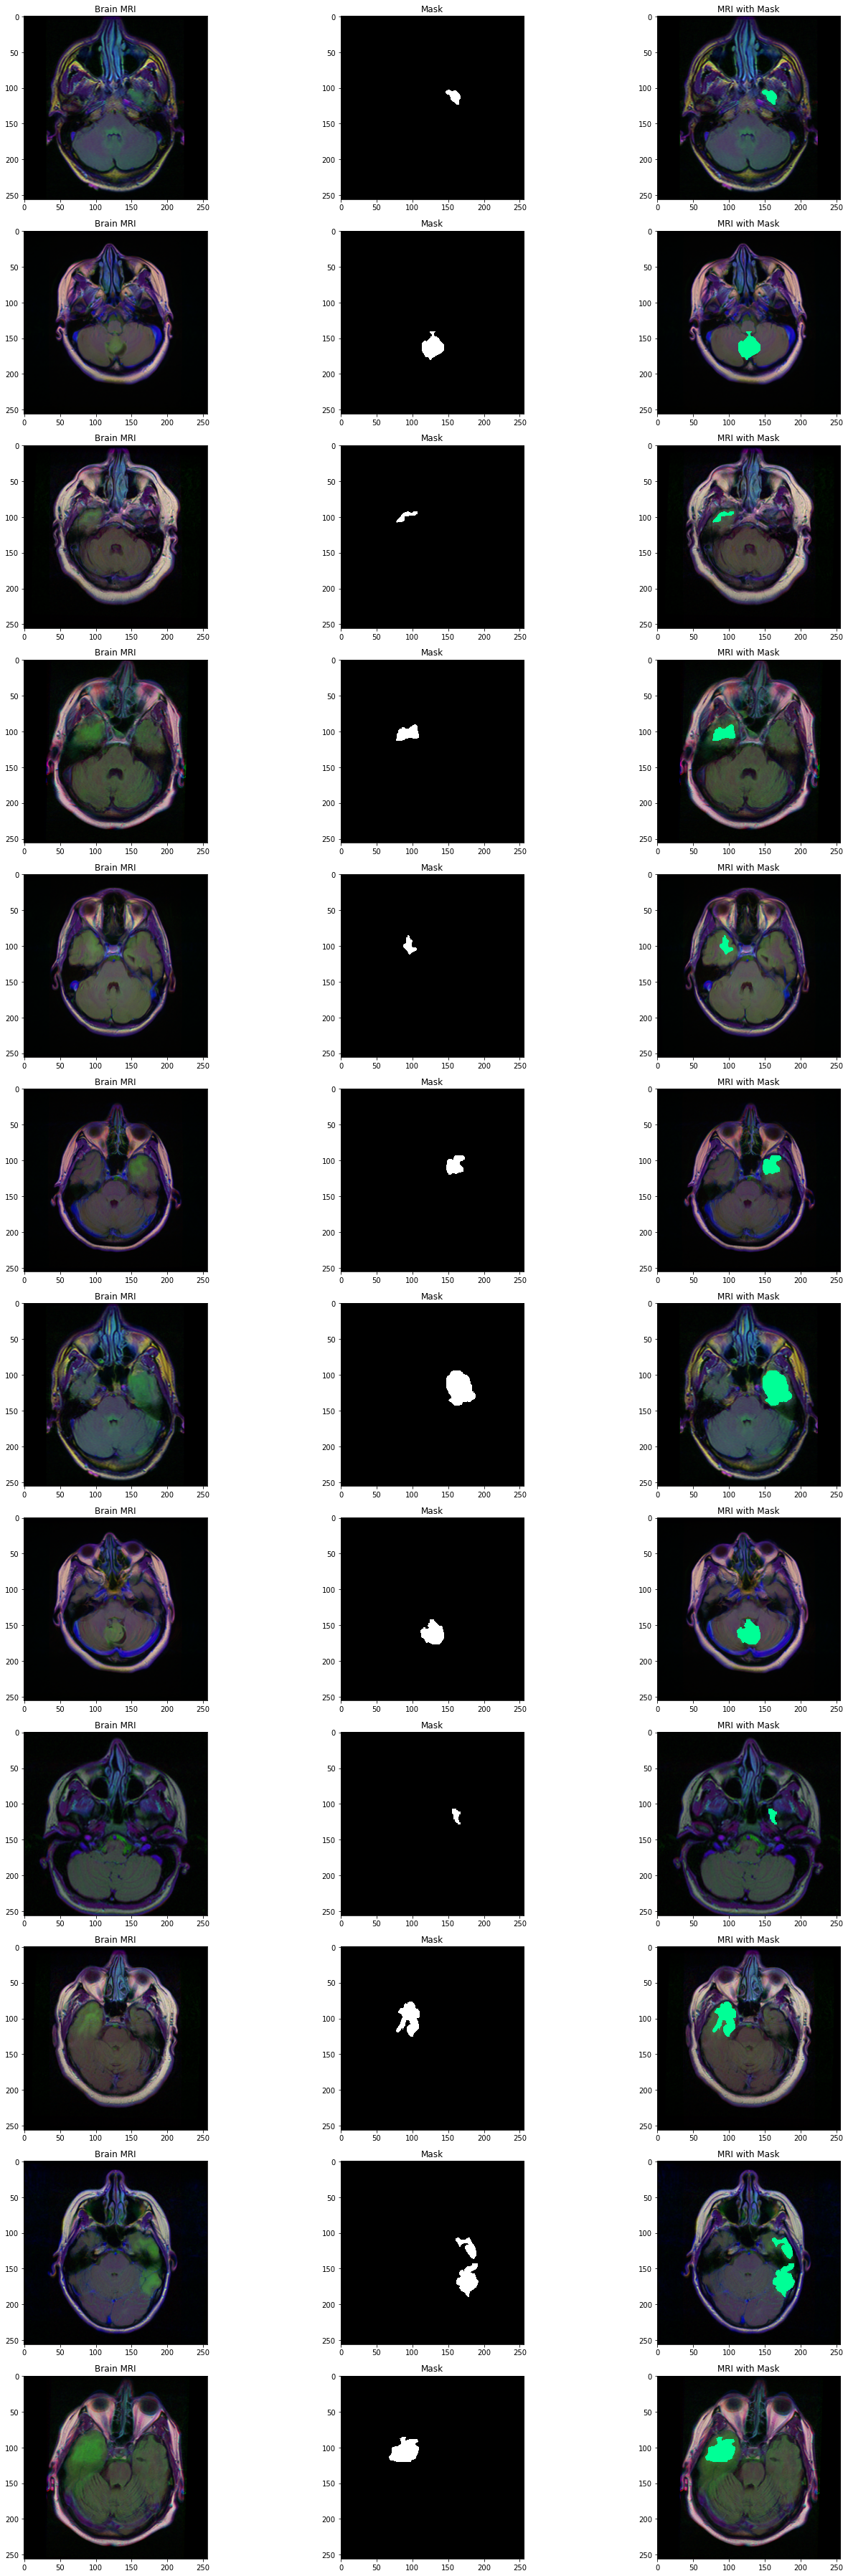

In [13]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# 5: CRETING TEST, TRAIN & VAL SET

In [14]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [15]:
from sklearn.model_selection import train_test_split
SEED = 123456
import os
import random as rn
import numpy as np

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 123456)

In [16]:

from keras_preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1, rotation_range = 15, horizontal_flip = True, vertical_flip = True)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# 6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [17]:
"""#
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

#clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

#clf_model = VGG16(weights='imagenet', include_top=False)

clf_model.summary()"""

"#\nfrom keras import applications\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import ResNet101\nfrom tensorflow.keras.applications import VGG16\n\nclf_model = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))\n\n#clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))\n\n#clf_model = VGG16(weights='imagenet', include_top=False)\n\nclf_model.summary()"

In [18]:
# dir(applications)

In [19]:
"""# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False"""

'# before this i tried with trainable layer but the accuracy was less as compared\nfor layer in clf_model.layers:\n    layers.trainable = False'

In [20]:
"""head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()"""

'head = clf_model.output\nhead = AveragePooling2D(pool_size=(4,4))(head)\nhead = Flatten(name=\'Flatten\')(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(2, activation=\'softmax\')(head)\n\nmodel = Model(clf_model.input, head)\nmodel.compile(loss = \'categorical_crossentropy\', \n              optimizer=\'adam\', \n              metrics= ["accuracy"]\n             )\n# model.summary()'

In [21]:
"""earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet101-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]"""

'earlystopping = EarlyStopping(monitor=\'val_loss\', \n                              mode=\'min\', \n                              verbose=1, \n                              patience=15\n                             )\ncheckpointer = ModelCheckpoint(filepath="clf-resnet101-weights.hdf5", \n                               verbose=1, \n                               save_best_only=True\n                              )\nreduce_lr = ReduceLROnPlateau(monitor=\'val_loss\',\n                              mode=\'min\',\n                              verbose=1,\n                              patience=10,\n                              min_delta=0.0001,\n                              factor=0.2\n                             )\ncallbacks = [checkpointer, earlystopping, reduce_lr]'

In [22]:
"""h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])"""

'h = model.fit(train_generator, \n              steps_per_epoch= train_generator.n // train_generator.batch_size, \n              epochs = 50, \n              validation_data= valid_generator, \n              validation_steps= valid_generator.n // valid_generator.batch_size, \n              callbacks=[checkpointer, earlystopping])'

In [23]:
"""# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet101-model.json", "w") as json_file:
    json_file.write(model_json)"""

'# saving model achitecture in json file\nmodel_json = model.to_json()\nwith open("clf-resnet101-model.json", "w") as json_file:\n    json_file.write(model_json)'

# 7: CLASSIFIACTION MODEL EVALUATION

In [24]:
"""h.history.keys()"""

'h.history.keys()'

In [25]:
"""plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);"""

'plt.figure(figsize=(12,5))\nplt.subplot(1,2,1)\nplt.plot(h.history[\'loss\']);\nplt.plot(h.history[\'val_loss\']);\nplt.title("Classification Model LOSS");\nplt.ylabel("loss");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);\n\nplt.subplot(1,2,2)\nplt.plot(h.history[\'accuracy\']);\nplt.plot(h.history[\'val_accuracy\']);\nplt.title("Classification Model Acc");\nplt.ylabel("Accuracy");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);'

In [26]:
"""_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))
stop"""

'_, acc = model.evaluate(test_generator)\nprint("Test accuracy : {} %".format(acc*100))\nstop'

In [27]:
"""prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
print(original)
print(pred)"""

"prediction = model.predict(test_generator)\n\npred = np.argmax(prediction, axis=1)\n#pred = np.asarray(pred).astype('str')\noriginal = np.asarray(test['mask']).astype('int')\n\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\naccuracy = accuracy_score(original, pred)\nprint(accuracy)\n\ncm = confusion_matrix(original, pred)\n\nreport = classification_report(original, pred, labels = [0,1])\nprint(report)\nplt.figure(figsize = (5,5))\nsns.heatmap(cm, annot=True);\nprint(original)\nprint(pred)"

In [28]:
"""for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
        """

'for i in range(len(original)):\n    if original[i] == 1 and pred[i] == 0:\n        print("false negative", i)\n    if original[i] == 0 and pred[i] == 1:\n        print("false positive", i)\n        '

In [29]:
"""model.save("resnet101")"""


'model.save("resnet101")'

In [30]:
"""# run a different model using the same dataset and data split
import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet50-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("resnet50")

print(original)
print(pred)

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
"""

'# run a different model using the same dataset and data split\nimport tensorflow.keras.applications as applications\nfrom keras import applications\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import ResNet101\nfrom tensorflow.keras.applications import VGG16\n\nclf_model = ResNet50(weights=\'imagenet\', include_top=False, input_tensor=Input(shape=(256,256,3)))\n# clf_model.summary()\n\nhead = clf_model.output\nhead = AveragePooling2D(pool_size=(2,2))(head)\nhead = Flatten(name=\'Flatten\')(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(2, activation=\'softmax\')(head)\n\nmodel = Model(clf_model.input, head)\nmodel.compile(loss = \'categorical_crossentropy\', \n              optimizer=\'adam\', \n              metrics= ["accuracy"]\n             )\n# model.summary()\n\nearlystopping = EarlyStopping(monitor=\'val_loss\

In [31]:
"""# run a different model using the same dataset and data split
import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adagrad', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet50_2-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("resnet50_2")

print(original)
print(pred)

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
"""

'# run a different model using the same dataset and data split\nimport tensorflow.keras.applications as applications\nfrom keras import applications\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import ResNet101\nfrom tensorflow.keras.applications import VGG16\n\nclf_model = ResNet50(weights=\'imagenet\', include_top=False, input_tensor=Input(shape=(256,256,3)))\n# clf_model.summary()\n\nhead = clf_model.output\nhead = AveragePooling2D(pool_size=(4,4))(head)\nhead = Flatten(name=\'Flatten\')(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(128, activation=\'relu\')(head)\nhead = Dropout(0.2)(head)\nhead = Dense(2, activation=\'softmax\')(head)\n\nmodel = Model(clf_model.input, head)\nmodel.compile(loss = \'categorical_crossentropy\', \n              optimizer=\'adagrad\', \n              metrics= ["accuracy"]\n             )\n# model.summary()\n\nearlystopping = EarlyStopping(monitor=\'val_lo

17227776/17225924 [==============================] - 1s 0us/step
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.8010
Epoch 00001: val_loss improved from inf to 0.24044, saving model to clf-MobileNet-weights.hdf5
187/187 [==============================] - 78s 417ms/step - loss: 0.5170 - accuracy: 0.8010 - val_loss: 0.2404 - val_accuracy: 0.8969
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9110
Epoch 00002: val_loss did not improve from 0.24044
187/187 [==============================] - 55s 295ms/step - loss: 0.2679 - accuracy: 0.9110 - val_loss: 0.3253 - val_accuracy: 0.8719
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9254
Epoch 00003: val_loss improved from 0.24044 to 0.12321, saving model to clf-MobileNet-weights.hdf5
187/187 [==============================] - 56s 301ms/step - loss: 0.2173 - accuracy: 0.9254 - val_loss: 0.1232 - val_accuracy: 0.9563


'print(original)\nprint(pred)\n\nfor i in range(len(original)):\n    if original[i] == 1 and pred[i] == 0:\n        print("false negative", i)\n    if original[i] == 0 and pred[i] == 1:\n        print("false positive", i)\n'

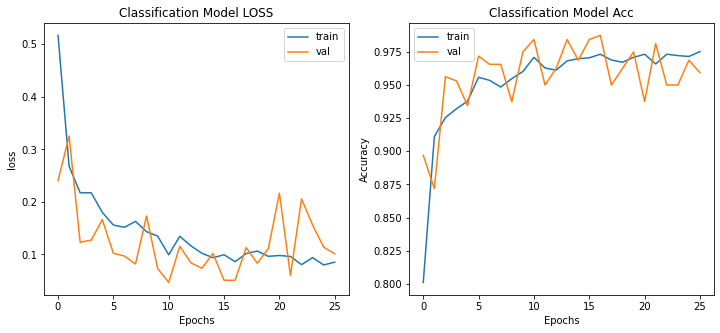

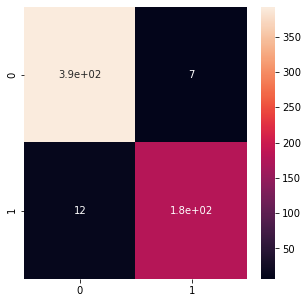

In [32]:
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.35)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])
"""
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)
"""
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNet")

"""print(original)
print(pred)

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
"""

Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7572
Epoch 00001: val_loss improved from inf to 0.33608, saving model to clf-MobileNet-2-weights.hdf5
187/187 [==============================] - 57s 303ms/step - loss: 0.5997 - accuracy: 0.7572 - val_loss: 0.3361 - val_accuracy: 0.8875
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8993
Epoch 00002: val_loss did not improve from 0.33608
187/187 [==============================] - 58s 312ms/step - loss: 0.3146 - accuracy: 0.8993 - val_loss: 1.2904 - val_accuracy: 0.7312
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9254
Epoch 00003: val_loss improved from 0.33608 to 0.27451, saving model to clf-MobileNet-2-weights.hdf5
187/187 [==============================] - 59s 318ms/step - loss: 0.2318 - accuracy: 0.9254 - val_loss: 0.2745 - val_accuracy: 0.9000
Epoch 4/50
187/187 [==============================] - ETA: 0s

'print(original)\nprint(pred)\n\nfor i in range(len(original)):\n    if original[i] == 1 and pred[i] == 0:\n        print("false negative", i)\n    if original[i] == 0 and pred[i] == 1:\n        print("false positive", i)\n'

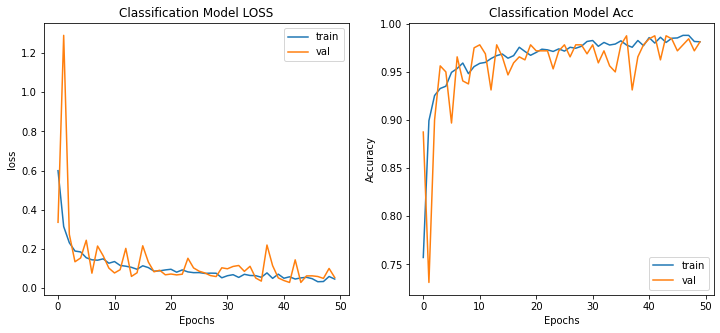

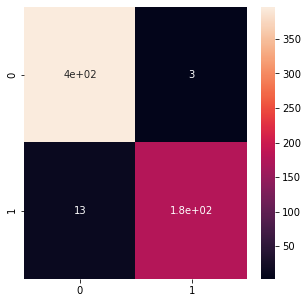

In [33]:
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNet-2-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])
"""
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)
"""
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNet-2")

"""print(original)
print(pred)

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
"""

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.6241
Epoch 00001: val_loss improved from inf to 0.60781, saving model to clf-VGG16-weights.hdf5
187/187 [==============================] - 59s 314ms/step - loss: 0.7039 - accuracy: 0.6241 - val_loss: 0.6078 - val_accuracy: 0.6313
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.6475
Epoch 00002: val_loss did not improve from 0.60781
187/187 [==============================] - 61s 326ms/step - loss: 0.6478 - accuracy: 0.6475 - val_loss: 0.6496 - val_accuracy: 0.6469
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6475
Epoch 00003: val_loss did not improve from 0.60781
187/187 [==============================] - 61s 325ms/step - loss: 0.6482 - accuracy: 0.6475 - val_loss: 0.6583 - val_accuracy: 0.6313
Epoch 4/50
187/187 [==============================] 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



'print(original)\nprint(pred)\n\nfor i in range(len(original)):\n    if original[i] == 1 and pred[i] == 0:\n        print("false negative", i)\n    if original[i] == 0 and pred[i] == 1:\n        print("false positive", i)\n'

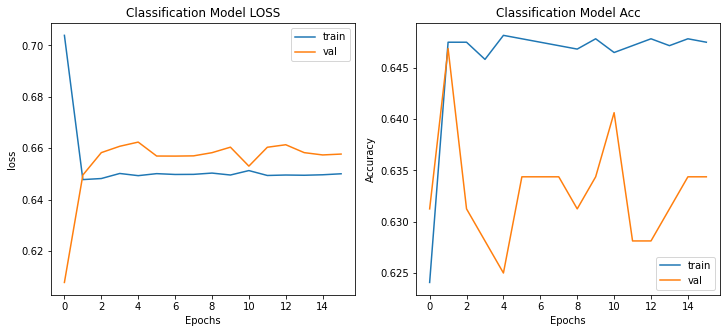

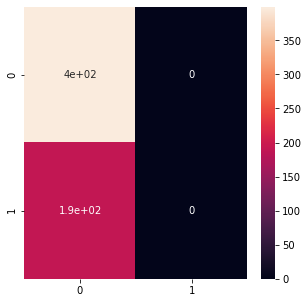

In [34]:
# run a different model using the same dataset and data split
import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()


for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.35)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-VGG16-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])
"""
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)
"""
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("VGG16")

"""print(original)
print(pred)

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
"""

Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.6375
Epoch 00001: val_loss improved from inf to 0.54213, saving model to clf-VGG19-weights.hdf5
187/187 [==============================] - 58s 312ms/step - loss: 0.7853 - accuracy: 0.6375 - val_loss: 0.5421 - val_accuracy: 0.7500
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.6756
Epoch 00002: val_loss did not improve from 0.54213
187/187 [==============================] - 61s 328ms/step - loss: 0.6178 - accuracy: 0.6756 - val_loss: 0.6531 - val_accuracy: 0.6406
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6475
Epoch 00003: val_loss did not improve from 0.54213
187/187 [==============================] - 61s 327ms/step - loss: 0.6502 - accuracy: 0.6475 - val_loss: 0.6532 - val_accuracy: 0.6406
Epoch 4/50
187/187 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.6482
Epoch 00004: val_loss

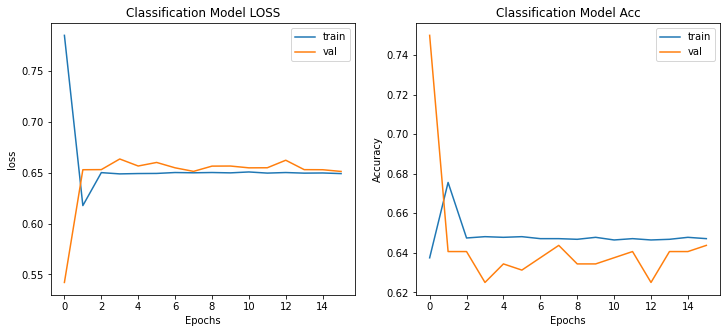

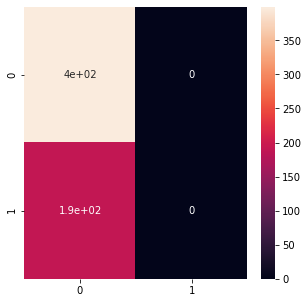

In [35]:
# run a different model using the same dataset and data split
import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG19

clf_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()


for layer in clf_model.layers:
    layers.trainable = False

head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.35)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-VGG19-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])
"""
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet50-model.json", "w") as json_file:
    json_file.write(model_json)
"""
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("VGG19")


# 8: BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [36]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [37]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [38]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

![alt text](https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH)

![alt text](https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD)

In [39]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [40]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

# 9: TRAINING SEGMENTATION MODEL

In [41]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [42]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [43]:
h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - ETA: 0s - loss: 0.8533 - tversky: 0.1898
Epoch 00001: val_loss improved from inf to 0.81524, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 9s 129ms/step - loss: 0.8533 - tversky: 0.1898 - val_loss: 0.8152 - val_tversky: 0.2382
Epoch 2/60
72/72 [==============================] - ETA: 0s - loss: 0.5360 - tversky: 0.5601
Epoch 00002: val_loss improved from 0.81524 to 0.62267, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 9s 118ms/step - loss: 0.5360 - tversky: 0.5601 - val_loss: 0.6227 - val_tversky: 0.4659
Epoch 3/60
72/72 [==============================] - ETA: 0s - loss: 0.4051 - tversky: 0.6979
Epoch 00003: val_loss improved from 0.62267 to 0.61204, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 8s 117ms/step - loss: 0.4051 - tversky: 0.6979 - val_loss: 0.6120 - val_tversky: 0.4795
Epoch 4/60
72/72 [==============

In [44]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

# 10: SEGMENTATION MODEL EVALUATION

In [45]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

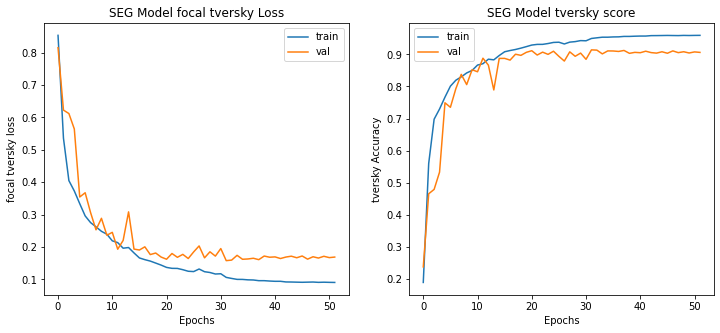

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [47]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 0s 82ms/step - loss: 0.1792 - tversky: 0.8986
Segmentation tversky is 89.86%


# 11: SEGMENTATION MODEL PREFORMACE 
## (COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [48]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [49]:
# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

,image_path,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
...,...,...,...
585,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
586,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
587,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
588,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0


In [50]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

,image_path,mask_path,mask,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,No mask :),0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
5,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
6,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
7,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
8,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
9,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0


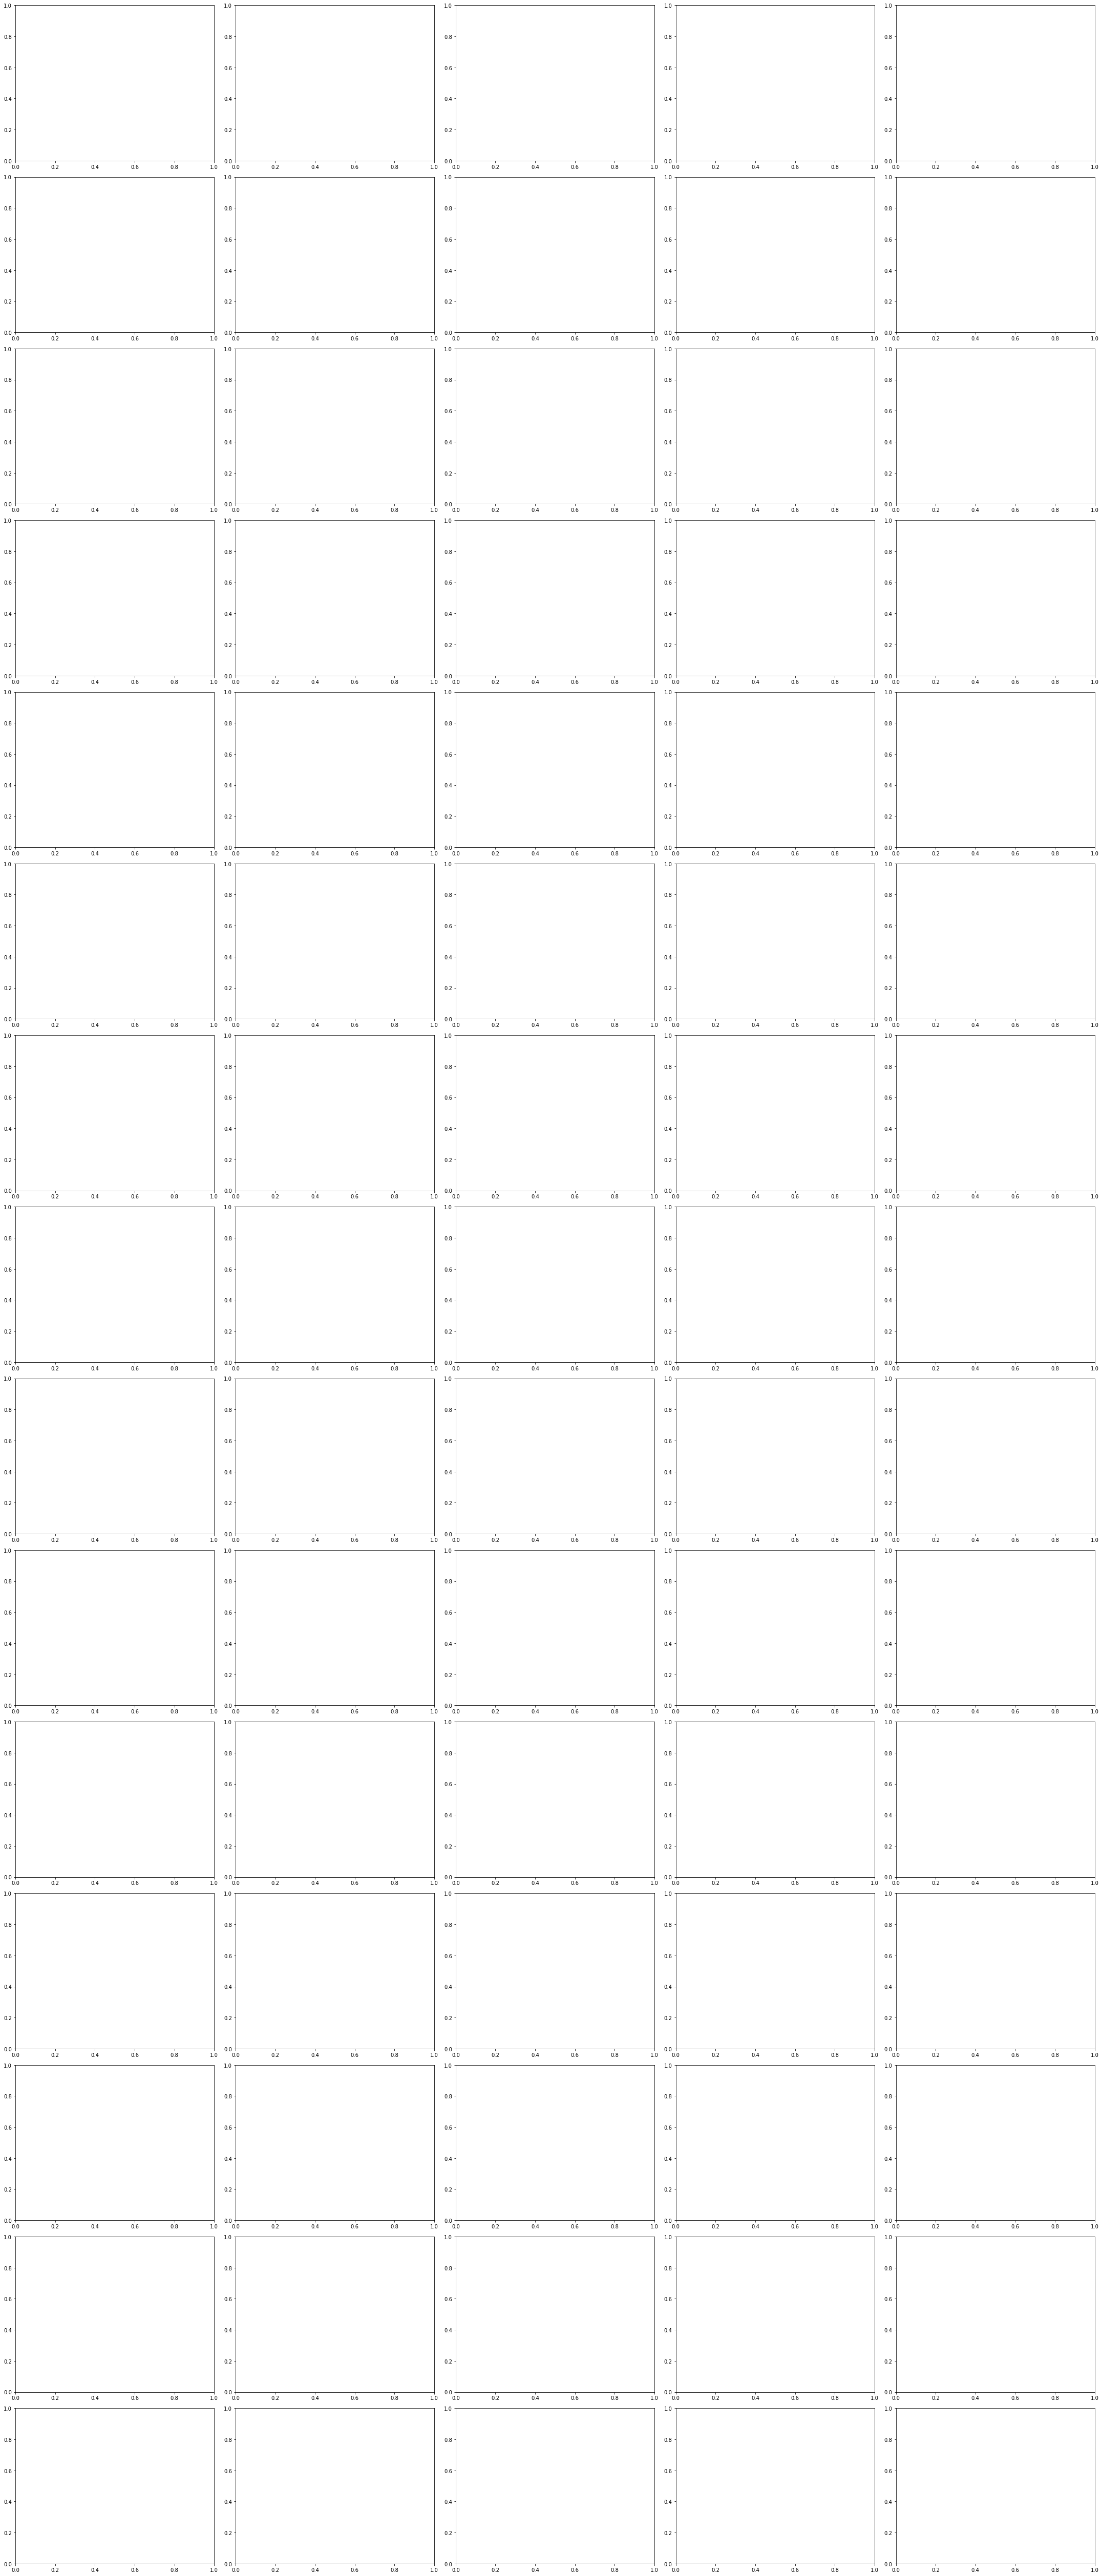

In [51]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        

the predictions made by AI are almost correct :)